In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))
import itertools

import multiprocessing

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import bottleneck as bn
import pandas as pd
from sklearn import decomposition
import networkx as nx
# import networkx.algorithms.approximation as nxa
import igraph as ig
# # http://stackoverflow.com/questions/35279733/what-could-cause-networkx-pygraphviz-to-work-fine-alone-but-not-together
# from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid", {"axes.facecolor": ".95"})
import missingno as msno
import palettable
%matplotlib inline

from collections import defaultdict, Counter
from IPython.display import display as disp

from speclib.loaders import *
from speclib.plotting import *
from speclib.graph import *
from speclib.misc import *
from speclib.userActivityFunctions import *

for k, v in {'font.size': 13.0,
             'legend.fontsize': 13.0,
             'axes.labelsize': 12.0,
             'axes.titlesize': 15.0,
             'figure.figsize': [16.0, 7.0],
             'figure.dpi': 200,
             'figure.titlesize': 'large',
             'xtick.labelsize': 13.0,
             'ytick.labelsize': 13.0}.items():
    mpl.rcParams[k] = v

%load_ext watermark
%watermark -a "Allan Leander Rostock Hansen" -u -d -v -p numpy,bottleneck,pandas,matplotlib,sklearn,missingno
%watermark  -p networkx,igraph,seaborn,palettable

Allan Leander Rostock Hansen 
last updated: 2017-03-23 

CPython 3.5.3
IPython 5.1.0

numpy 1.12.0
bottleneck 1.2.0
pandas 0.19.1
matplotlib 2.0.0
sklearn 0.18.1
missingno 0.3.4
networkx 2.0.dev_20170307140417
igraph 0.7.1
seaborn 0.7.1
palettable 3.0.0


# Load and clean data

In [2]:
if os.path.isfile('phone_df.h5'):
    df = pd.io.pytables.read_hdf('phone_df.h5', 'df')
    import pickle
    with open('useralias.pk', 'br') as fid:
        ua = pickle.load(fid)
else:
    ua = Useralias()
    userSpec = [(user, ua[user], ('sms', 'call')) for user in getUserList()]
    userData = loadUserParallel(userSpec) 
    df = users2DataFrame(userData, ua)
    del userData
phonebook = loadUserPhonenumberDict(ua) 
df.head() 

body  duration  hour                                    number  \
user  comtype                                                                  
u0001 call     NaN      29.0    15  36a4861f3f67cbf88b578d77743d1f5a8ddf604f   
      call     NaN       0.0    11  a7a089517b6855c7144c018e74ecced67a99e6f6   
      call     NaN      89.0    11  a7a089517b6855c7144c018e74ecced67a99e6f6   
      call     NaN     104.0    13  36a4861f3f67cbf88b578d77743d1f5a8ddf604f   
      call     NaN      32.0    18  36a4861f3f67cbf88b578d77743d1f5a8ddf604f   

                  timeint           timestamp  weekday  
user  comtype                                           
u0001 call     1386255771 2013-12-05 15:02:51        3  
      call     1386330792 2013-12-06 11:53:12        4  
      call     1386330838 2013-12-06 11:53:58        4  
      call     1386509631 2013-12-08 13:33:51        6  
      call     1386526906 2013-12-08 18:21:46        6

In [3]:
df = df.head() 

In [4]:
df.timeint.dt.hour

AttributeError: Can only use .dt accessor with datetimelike values

Remove call to users not in phonebook.

In [3]:
df = df[df.number.isin(phonebook)] 

Add _contactedUser_ column and remove the _number_ column.

In [4]:
df['contactedUser'] = df.number.apply(lambda x: phonebook[x]) 
df = df.drop('number', axis=1)

In [5]:
df.head() 

body  duration  hour     timeint           timestamp  weekday  \
user  comtype                                                                 
u0001 call     NaN       0.0     1  1390698006 2014-01-26 01:00:06        6   
      call     NaN       0.0    14  1391176805 2014-01-31 14:00:05        4   
      call     NaN      29.0    14  1391782631 2014-02-07 14:17:11        4   
      call     NaN      22.0    14  1391782712 2014-02-07 14:18:32        4   
      call     NaN       3.0    14  1394805935 2014-03-14 14:05:35        4   

              contactedUser  
user  comtype                
u0001 call            u0493  
      call            u0493  
      call            u0117  
      call            u0493  
      call            u0117

## Check for obvious outliers

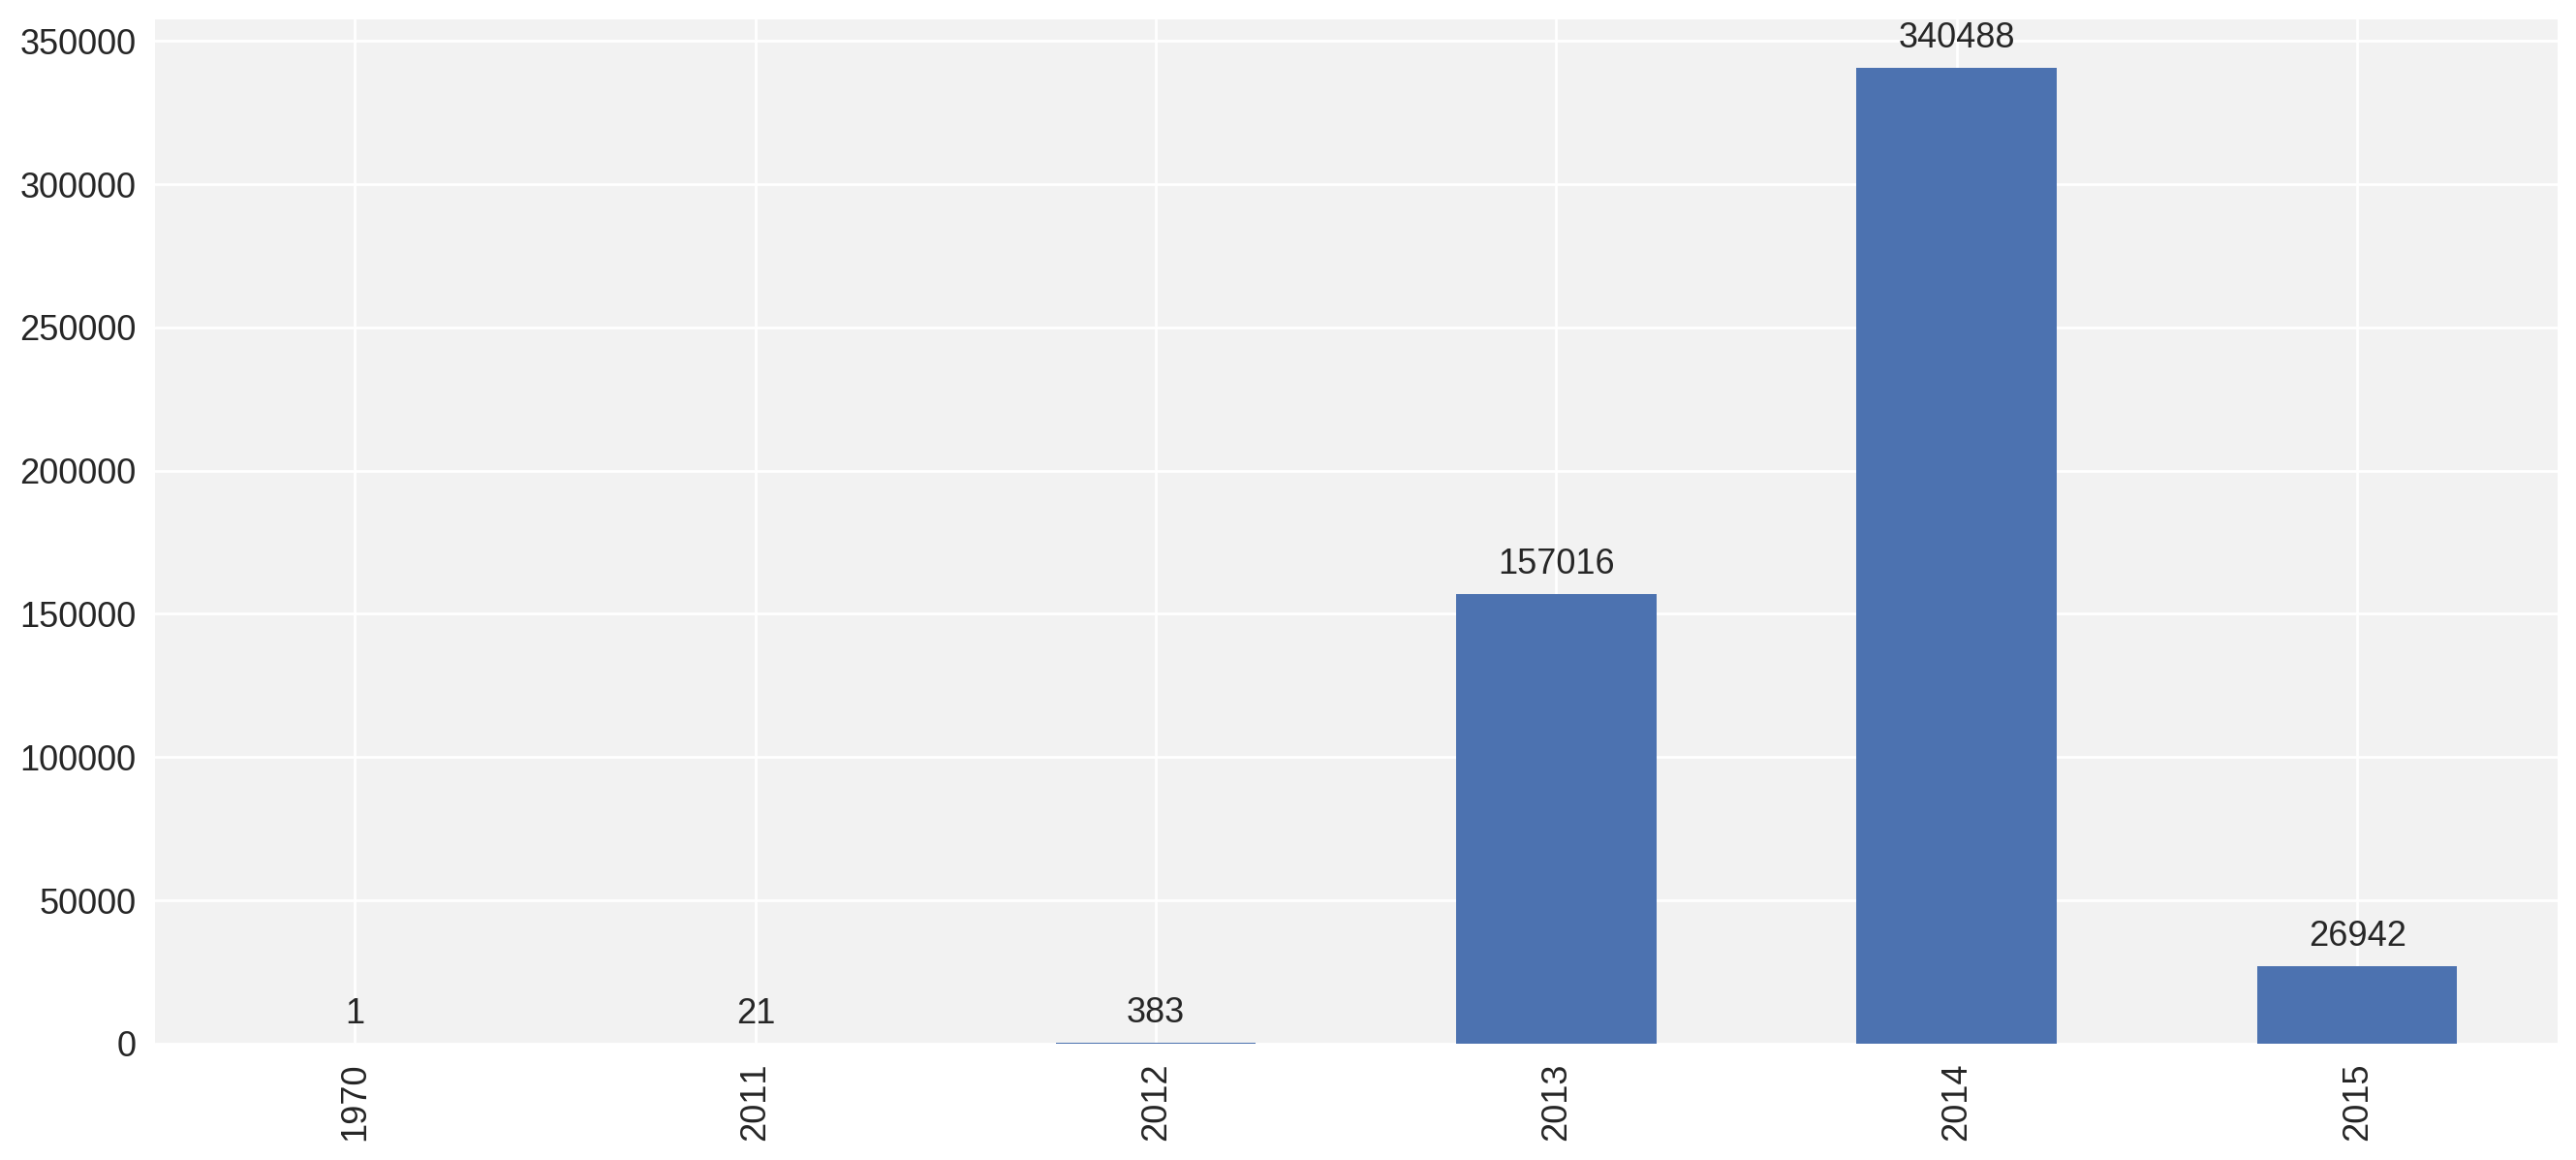

In [6]:
ax = df.timestamp.dt.year.value_counts().sort_index(ascending=True).plot.bar() 
countsOnBarPlot(ax) 

Remove data preceding 2013.

In [7]:
df = df[df.timestamp.dt.year >= 2013] 

## Remove entries with users contacting themself

In [8]:
tmp = df.reset_index()
tmp = tmp[(tmp.user != tmp.contactedUser)]
df = tmp.set_index(['user', 'comtype'], drop=False)
del tmp

# Turn data into a Networkx graph

In [9]:
g = userDF2nxGraph(df)

Ensure that the graph contains the correct number of nodes

In [10]:
assert len(list(g.nodes())) == len(set(df.index.get_level_values('user').tolist() + df.contactedUser.tolist())) 

## Analyse the graph

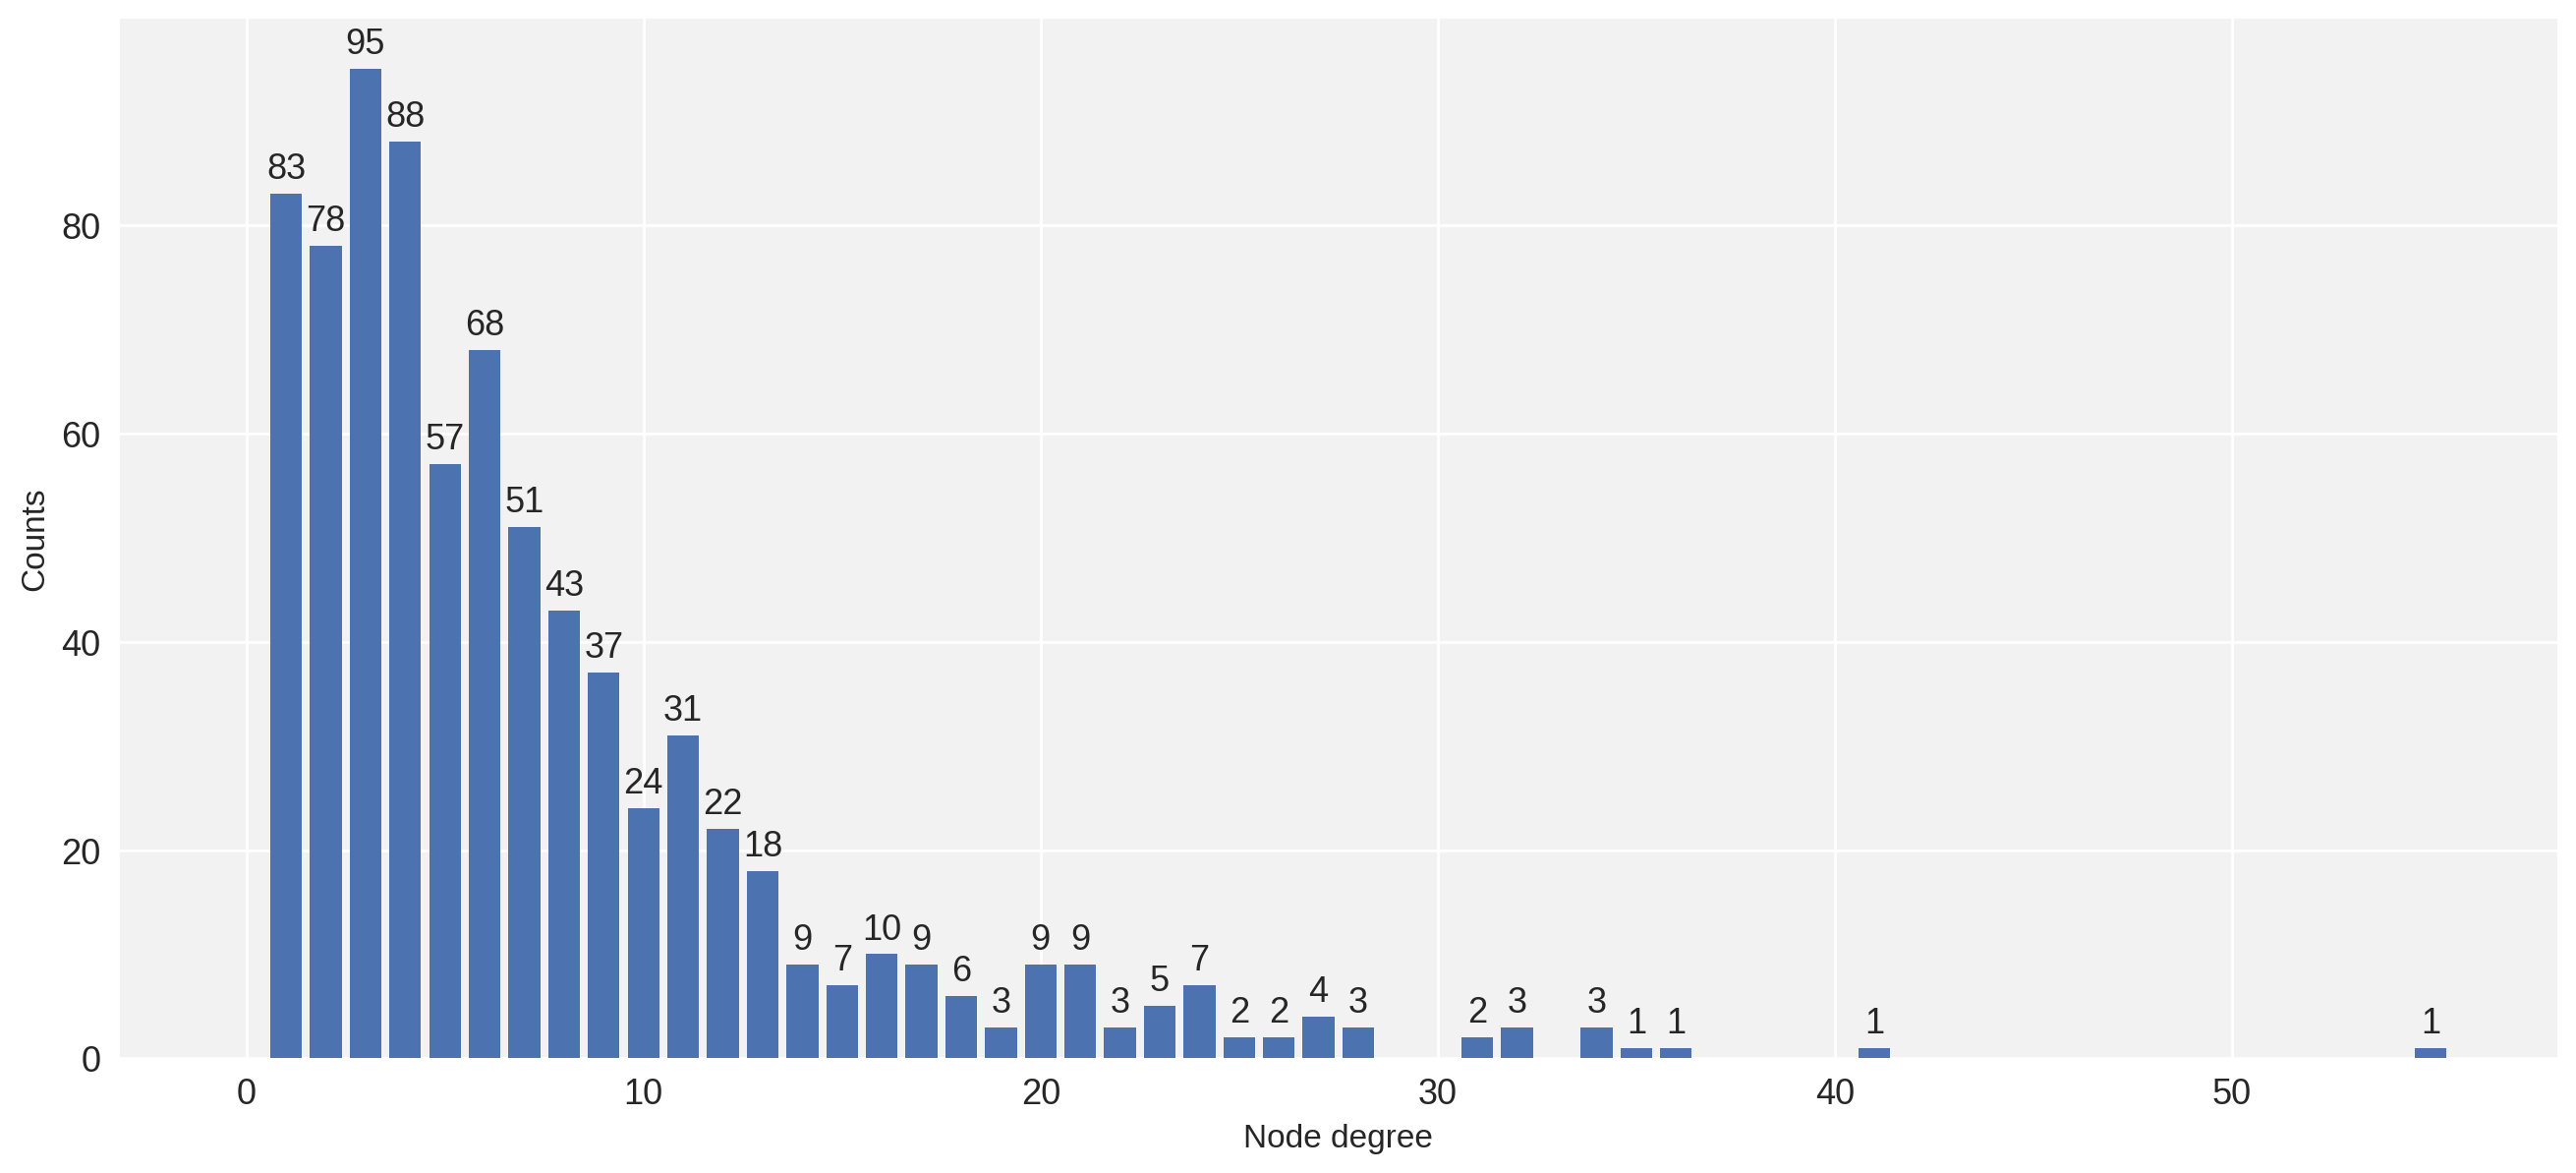

In [11]:
fig, ax = plt.subplots()
cnt = Counter(el[1] for el in g.degree())
x, y = list(zip(*((i, cnt[i]) for i in range(max(cnt)+1))))
ax.bar(x, y)
ax.set_xlabel('Node degree')
ax.set_ylabel('Counts')
countsOnBarPlot(ax) 

# Community detection

Find communities consisting of 5-cliques with a 4 degree connection between the cliques.

[From Documentation](http://networkx.readthedocs.io/en/latest/reference/generated/networkx.algorithms.community.kclique.k_clique_communities.html#networkx.algorithms.community.kclique.k_clique_communities):

> Find $k$-clique communities in graph using the percolation method.
> 
> A $k$-clique community is the union of all cliques of size $k$ that can be reached through adjacent (sharing $k-1$ nodes) $k$-cliques.

users,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
communityNumber,,,,,,,,,,,,,,,,,,,,,
0,u0154,u0444,u0150,u0489,u0423,u0324,u1023,u0441,u0128,u0491,...,u0758,u0818,u0108,u0951,u0210,u0228,u0973,u0463,u0287,u0813
1,u0073,u0211,u0122,u0214,u0324,u0503,u0930,u0146,u0859,u0392,...,u0047,u0889,u0607,None,None,None,None,None,None,None
2,u0211,u0709,u0478,u0493,u0612,u0392,u0122,u0241,u0739,u0264,...,None,None,None,None,None,None,None,None,None,None
3,u0808,u0586,u1040,u0506,u0786,u0183,u0930,u0583,u0233,u0226,...,None,None,None,None,None,None,None,None,None,None
4,u0808,u0318,u0813,u0568,u0721,u0324,u0228,u0176,u0287,u0544,...,None,None,None,None,None,None,None,None,None,None


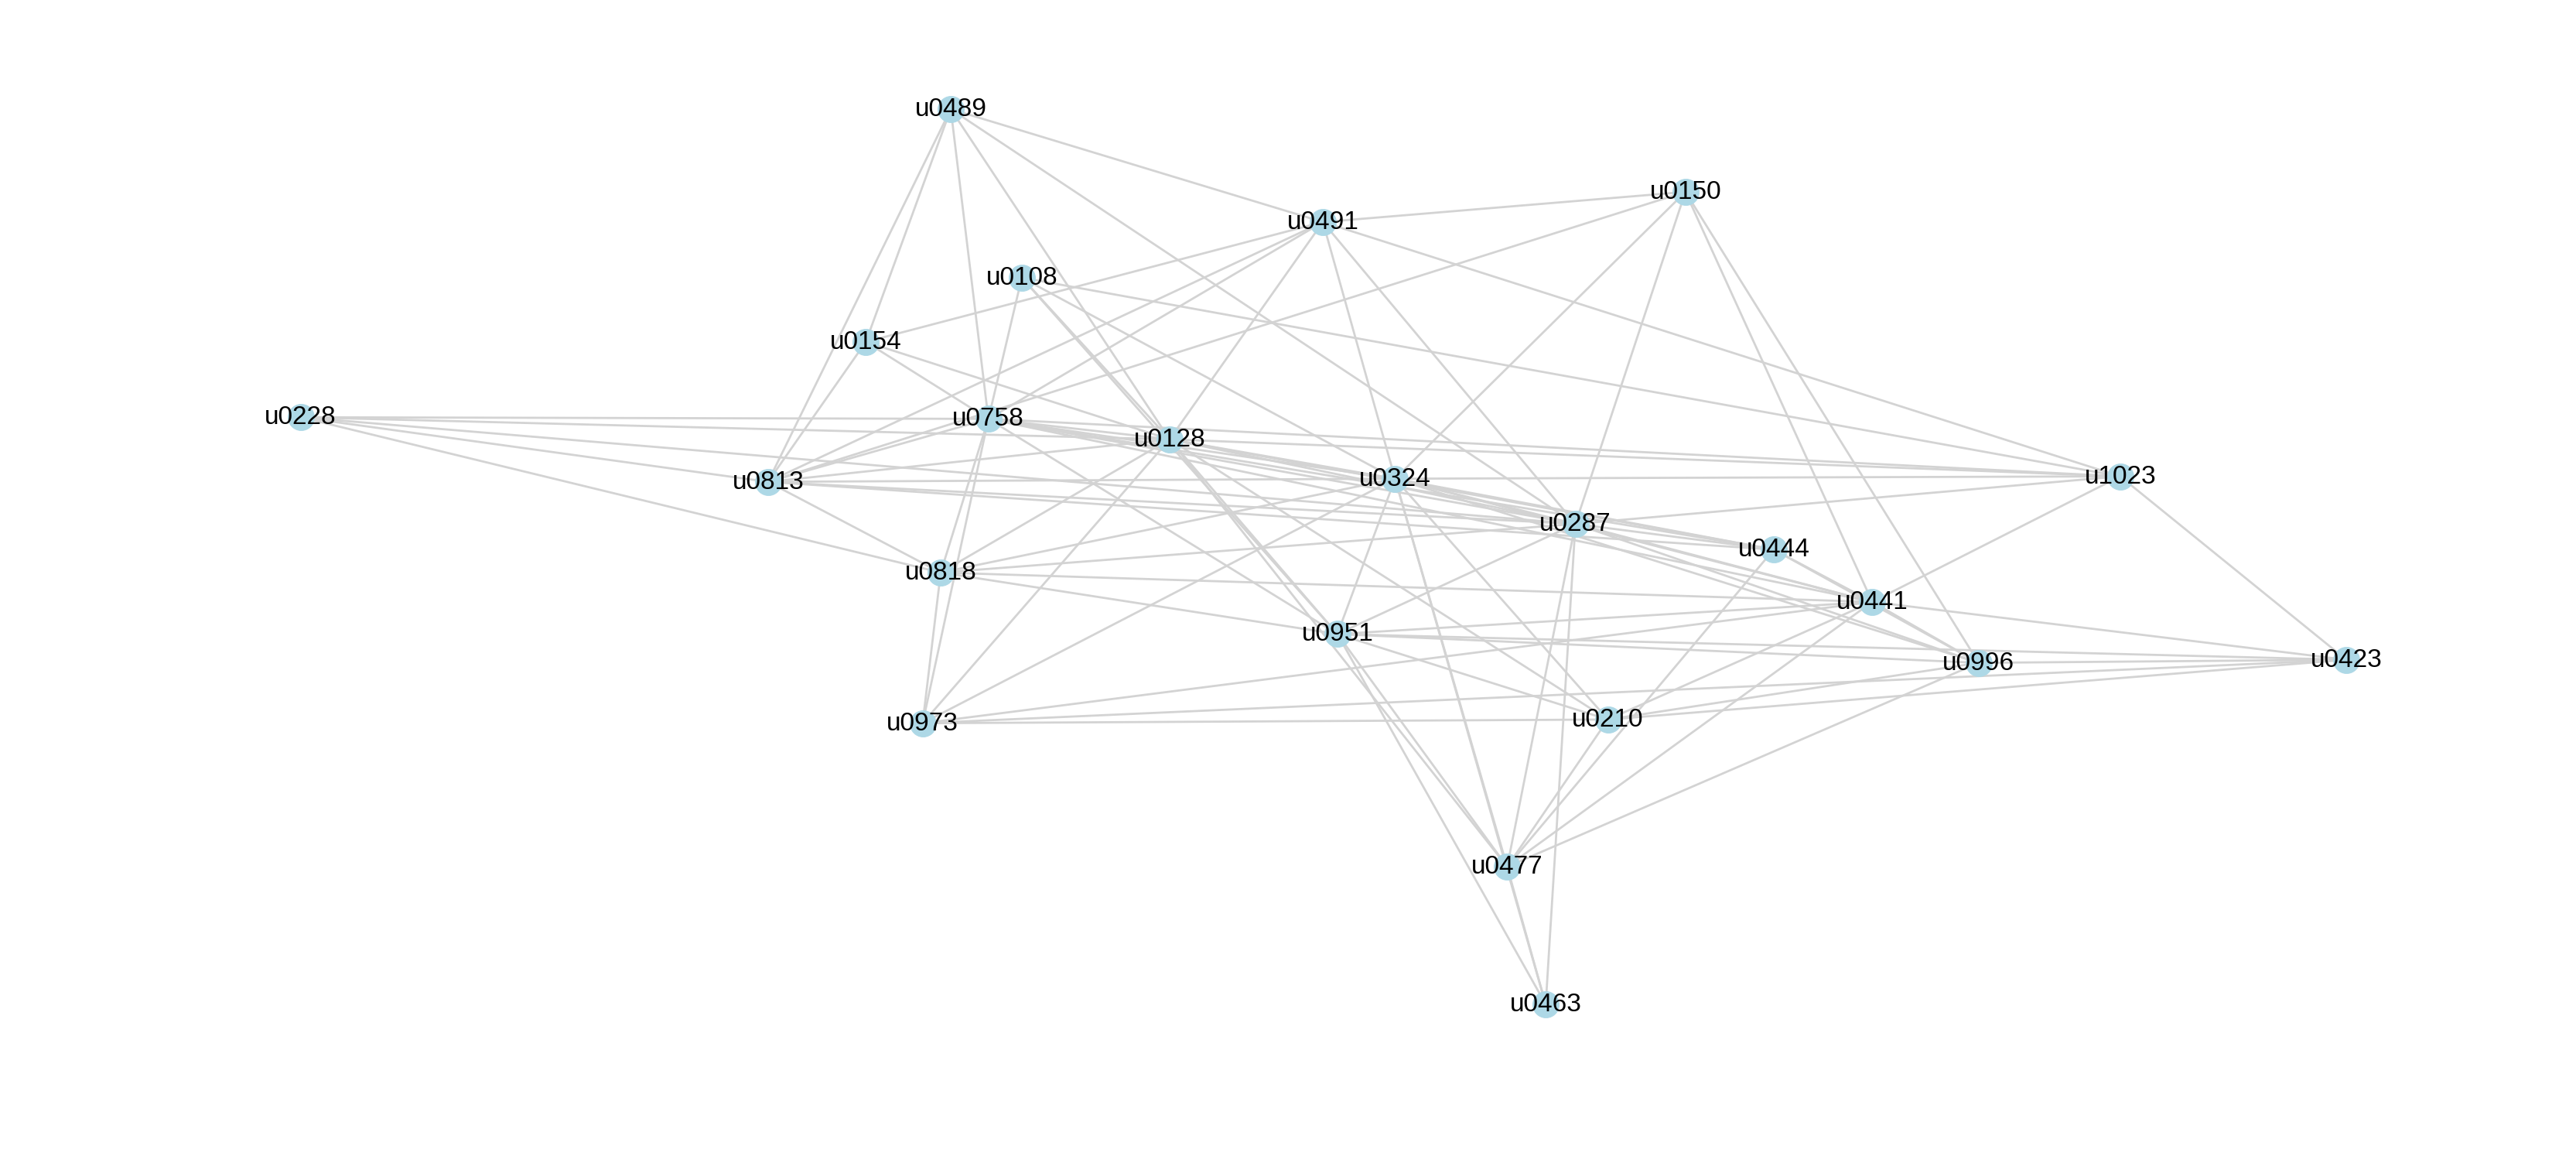

In [12]:
kcDf = pd.DataFrame(sorted(nx.algorithms.community.k_clique_communities(g, 5), key=lambda x: len(x), reverse=True))
kcDf.columns.name = 'users'
kcDf.index.name = 'communityNumber'
disp(kcDf.head())

gsc = g.subgraph(kcDf.iloc[0])
nxQuickDraw(gsc) 

kcDf['communitySize'] = kcDf.count(axis=1)

# Clique detection

Could be used for analysis of a larger network

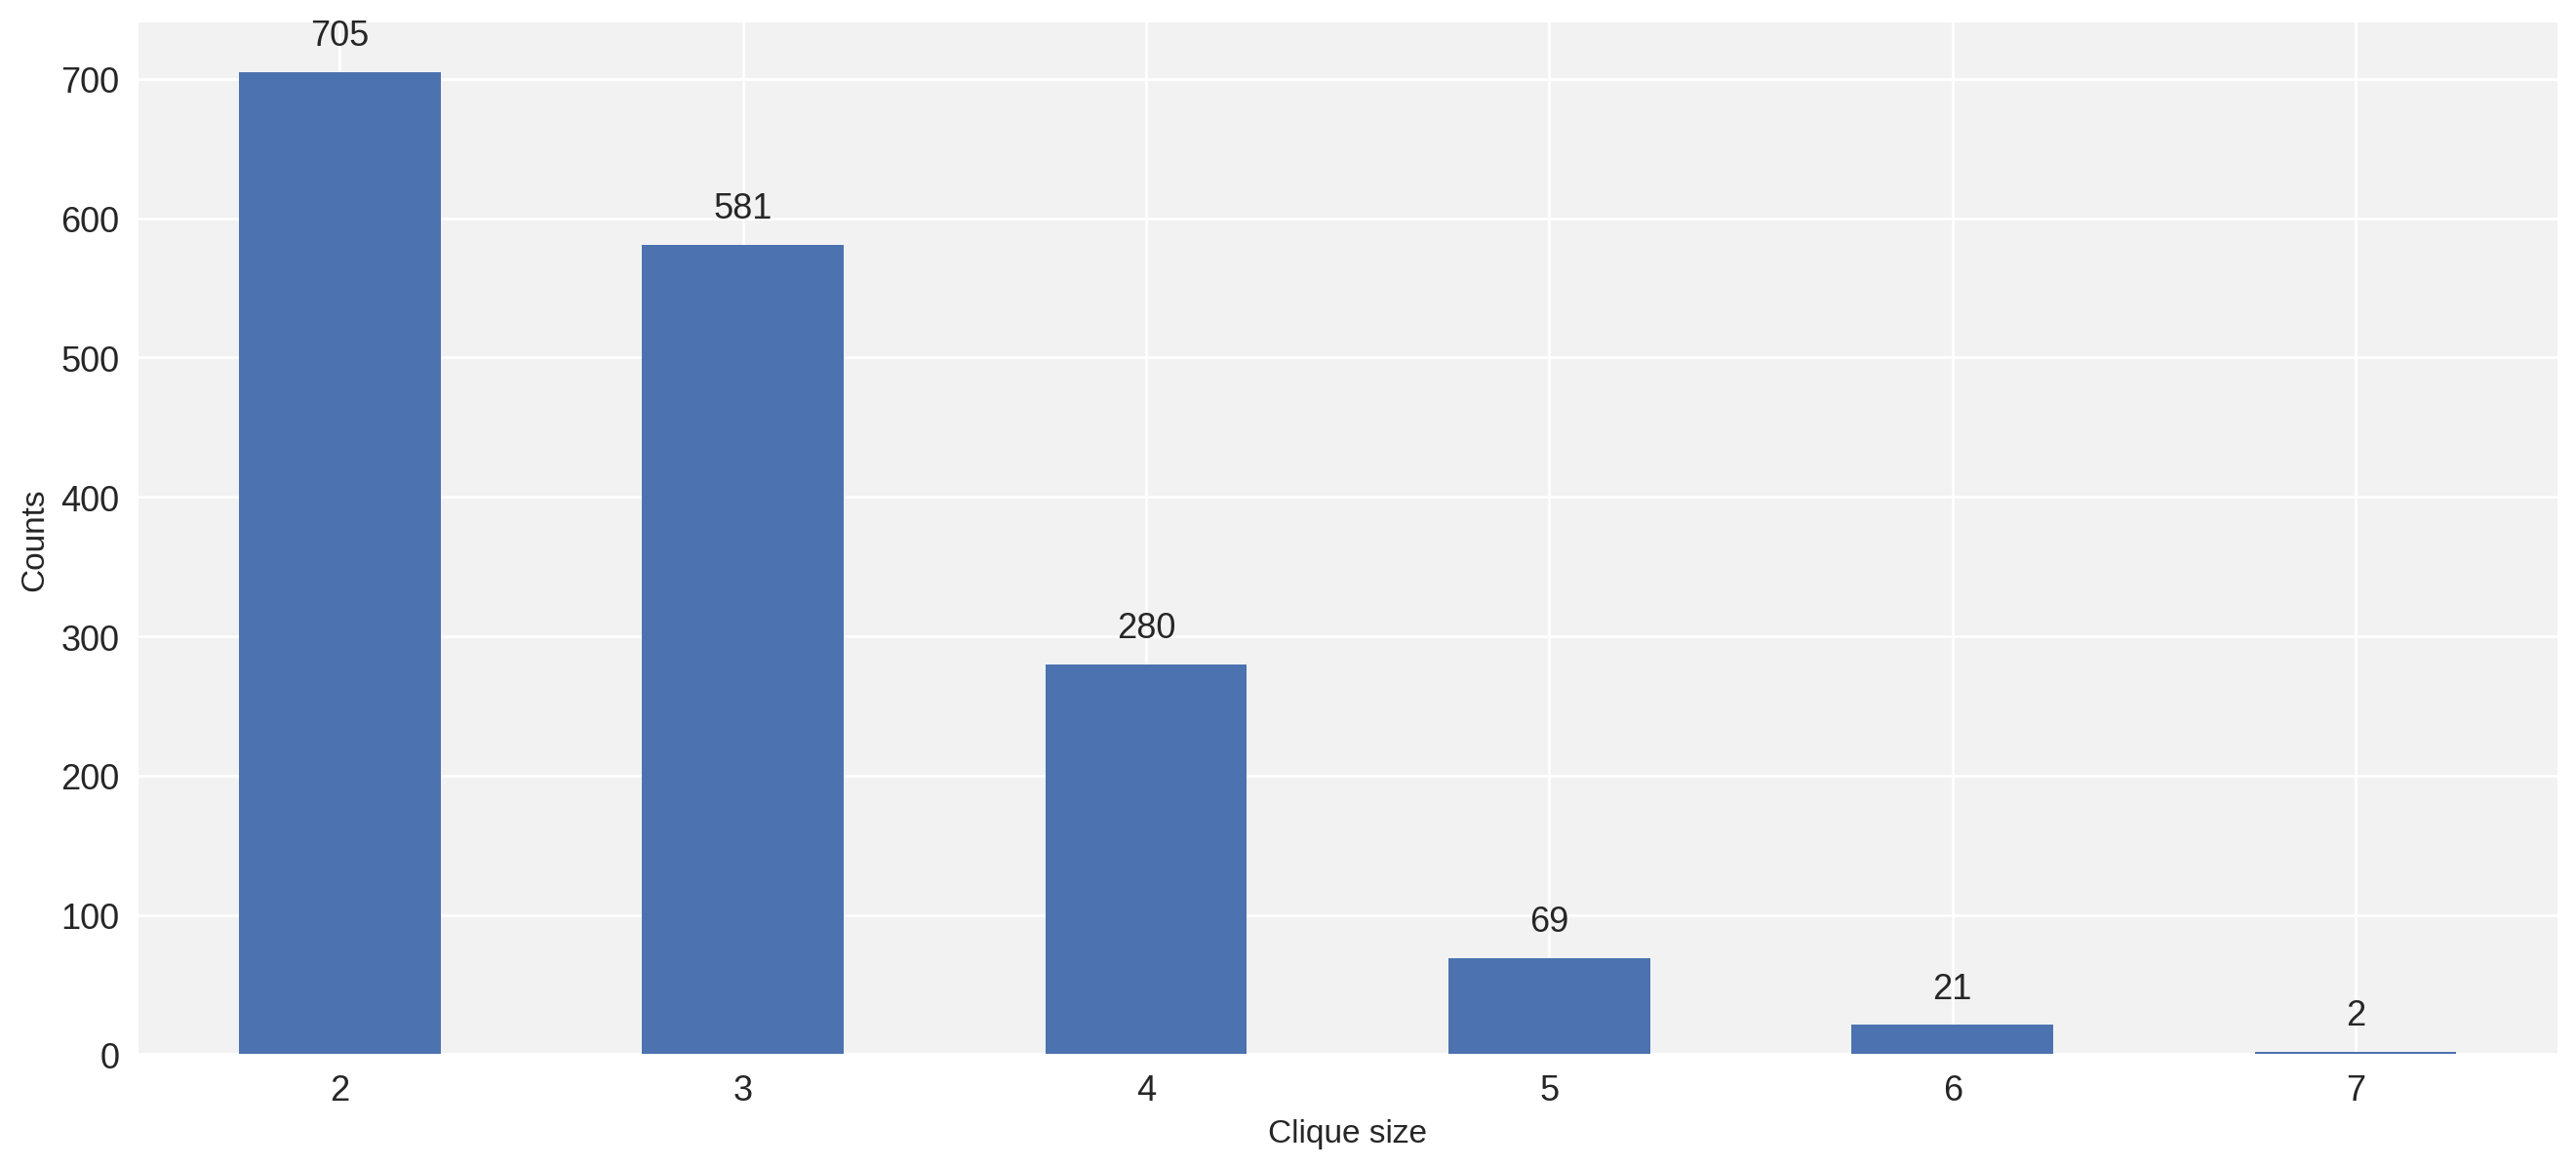

In [13]:
cliqueDf = pd.DataFrame(nx.clique.find_cliques_recursive(g))

cliqueDf['cliqueSize'] = cliqueDf.count(axis=1)
cliqueDf = cliqueDf.sort_values('cliqueSize', ascending=False)

ax = cliqueDf.cliqueSize.value_counts().sort_index().plot.bar(rot=0) 
ax.set_xlabel('Clique size') 
ax.set_ylabel('Counts') 
countsOnBarPlot(ax)

## Choose a clique with 5 users and make a subgraph 

In [14]:
df.head() 

user comtype body  duration  hour     timeint  \
user  comtype                                                   
u0001 call     u0001    call  NaN       0.0     1  1390698006   
      call     u0001    call  NaN       0.0    14  1391176805   
      call     u0001    call  NaN      29.0    14  1391782631   
      call     u0001    call  NaN      22.0    14  1391782712   
      call     u0001    call  NaN       3.0    14  1394805935   

                        timestamp  weekday contactedUser  
user  comtype                                             
u0001 call    2014-01-26 01:00:06        6         u0493  
      call    2014-01-31 14:00:05        4         u0493  
      call    2014-02-07 14:17:11        4         u0117  
      call    2014-02-07 14:18:32        4         u0493  
      call    2014-03-14 14:05:35        4         u0117

Chosen users:
u1021
u0342
u0693
u0571
u0613


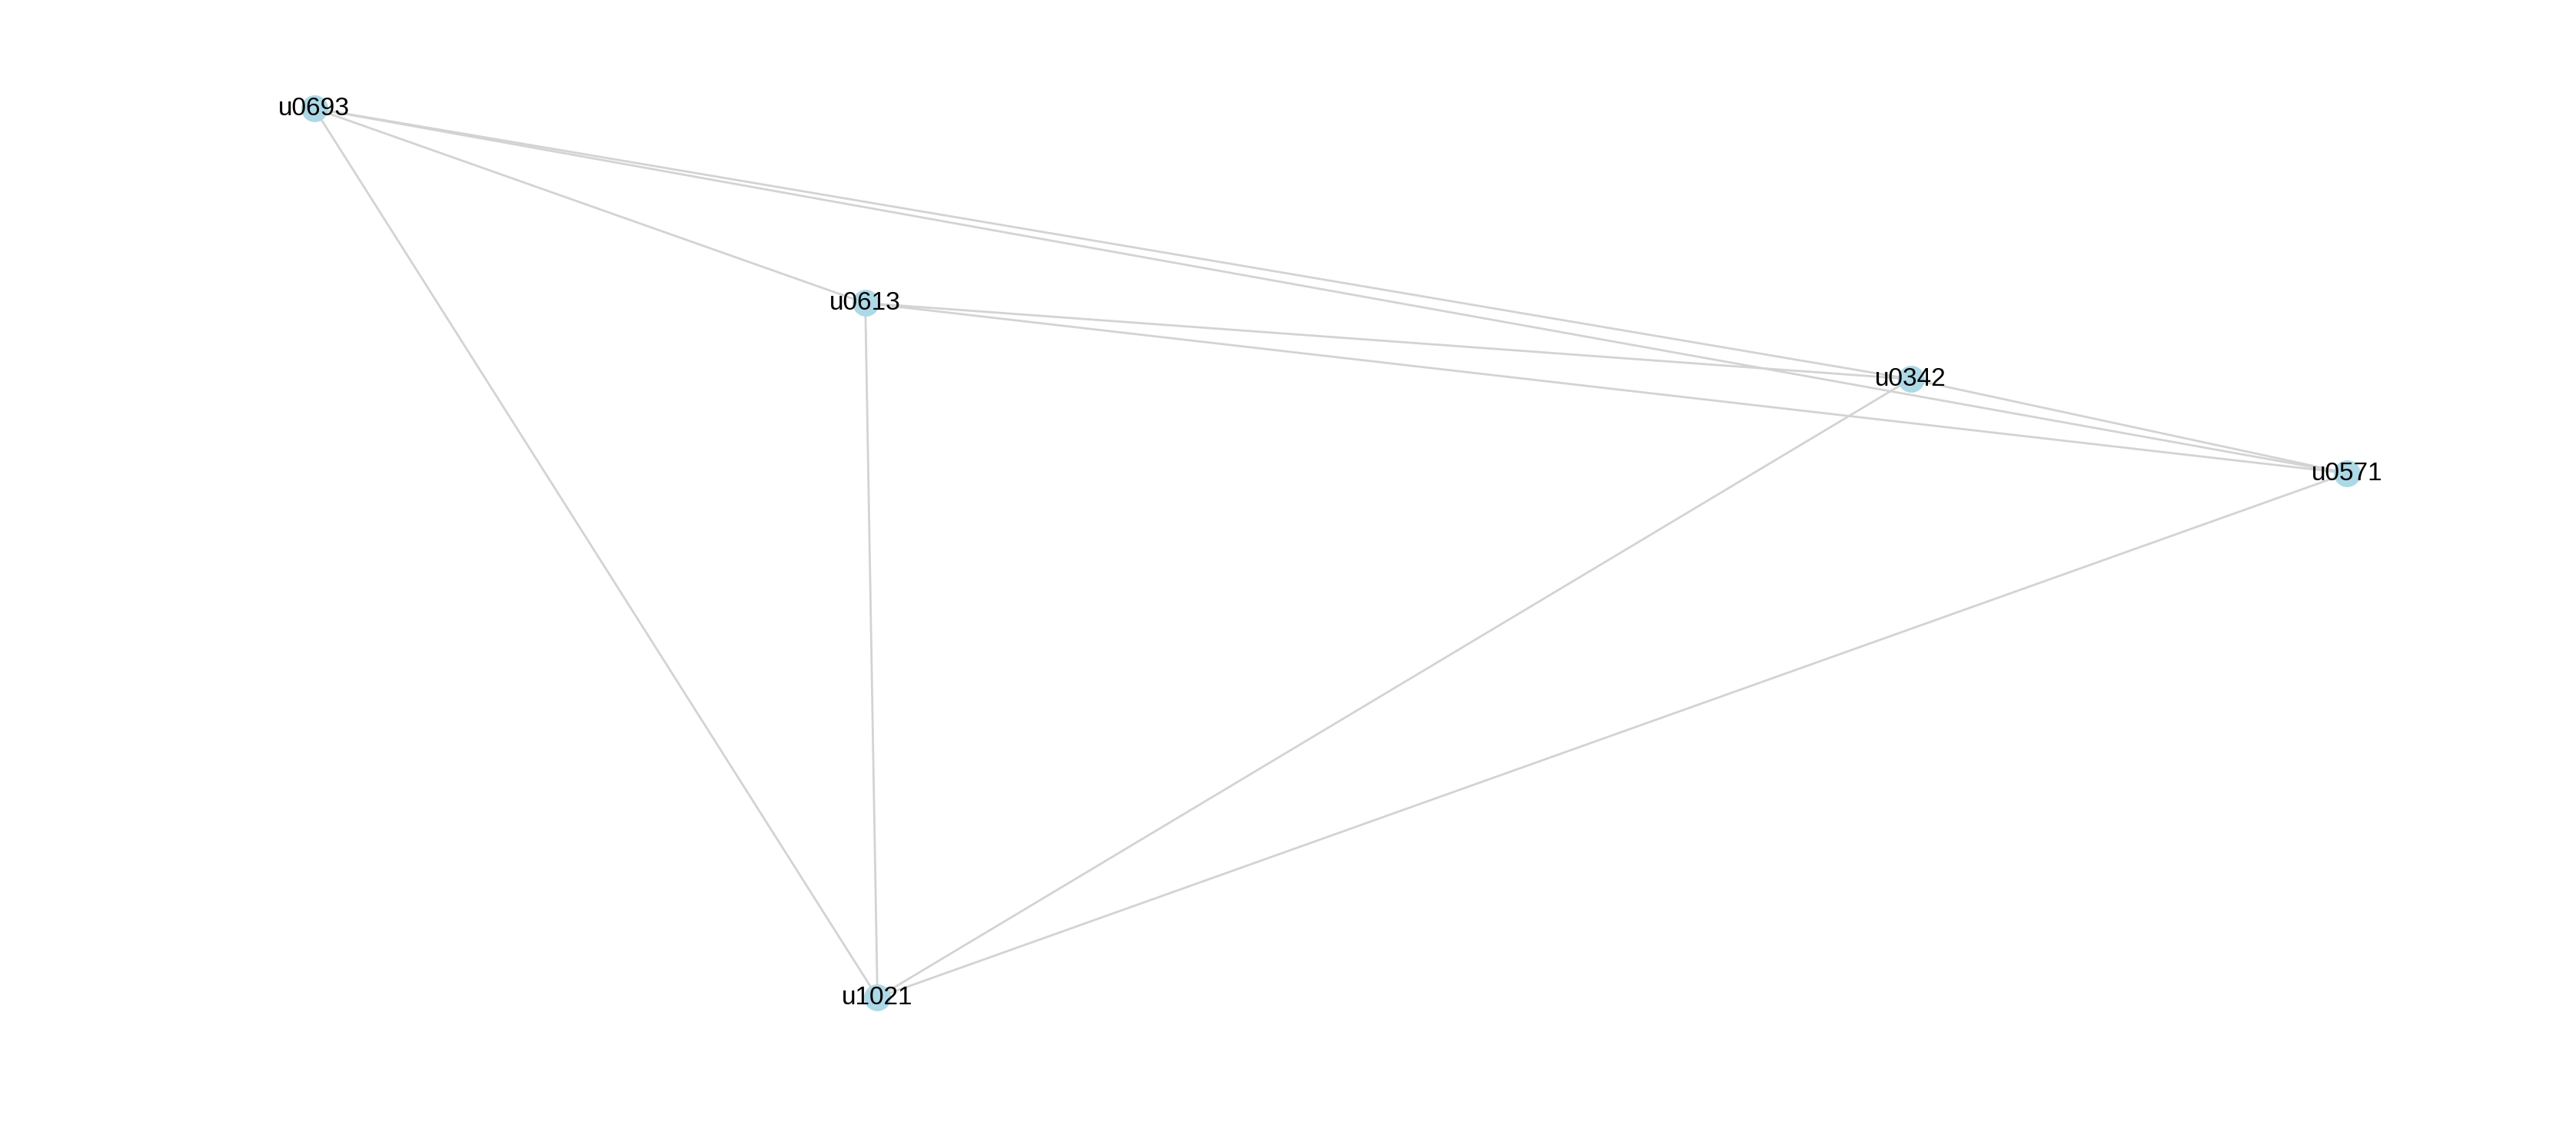

In [15]:
chosenUserLst = cliqueDf[cliqueDf.cliqueSize == 5].drop('cliqueSize', axis=1).iloc[1].dropna().tolist()
print("Chosen users:", *chosenUserLst, sep='\n') 
gs = g.subgraph(chosenUserLst)
nxQuickDraw(gs, plotSettings={'with_labels': True})

## Create timebinning for chosen users

Fraction of users contribution to communication

In [16]:
userDF2activityDataframe(df.loc[chosenUserLst]).sum(axis=1)

userInit
u0342    697.0
u0571     35.0
u0613    424.0
u0693    155.0
u1021     34.0
dtype: float64

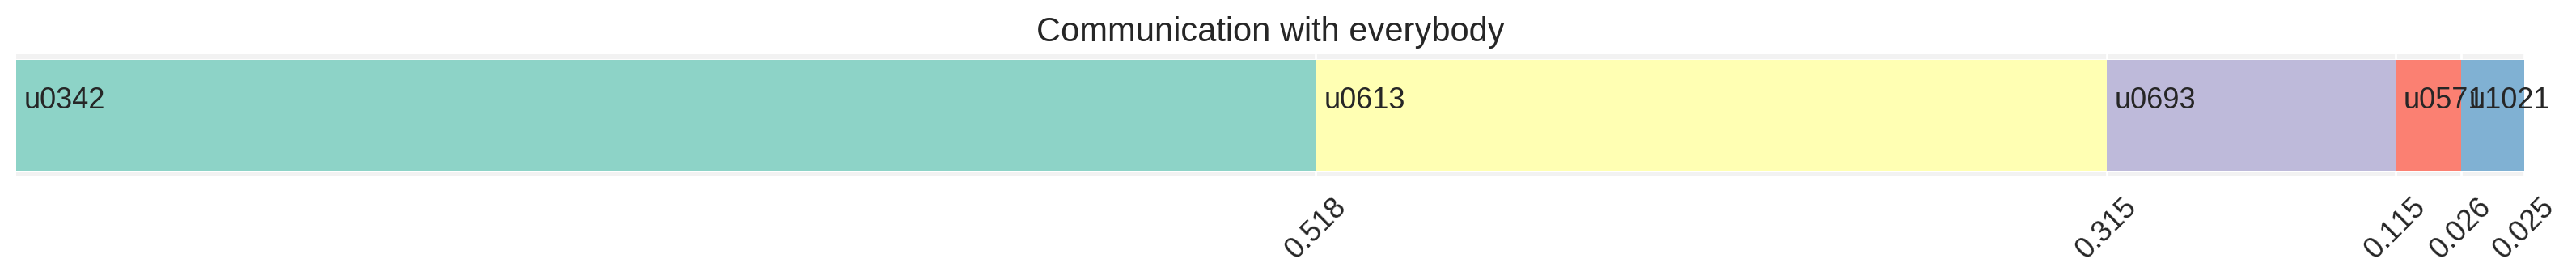

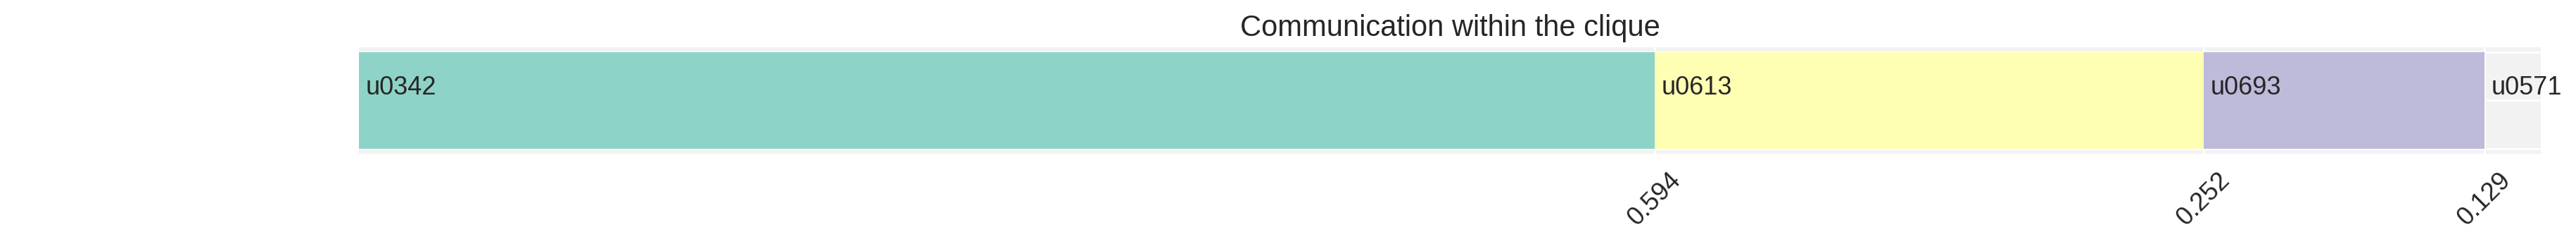

In [35]:
(ax, userOrder) = barFractionPlot(userDF2activityDataframe(df.loc[chosenUserLst]).sum(axis=1)) 
ax.set_title('Communication with everybody')
cliqueSubActDf = userDF2activityDataframe(userDf2CliqueDf(df, chosenUserLst)).sum(axis=1)
(ax, userOrder) = barFractionPlot(cliqueSubActDf, userOrder=userOrder) 
ax.set_title('Communication within the clique') 

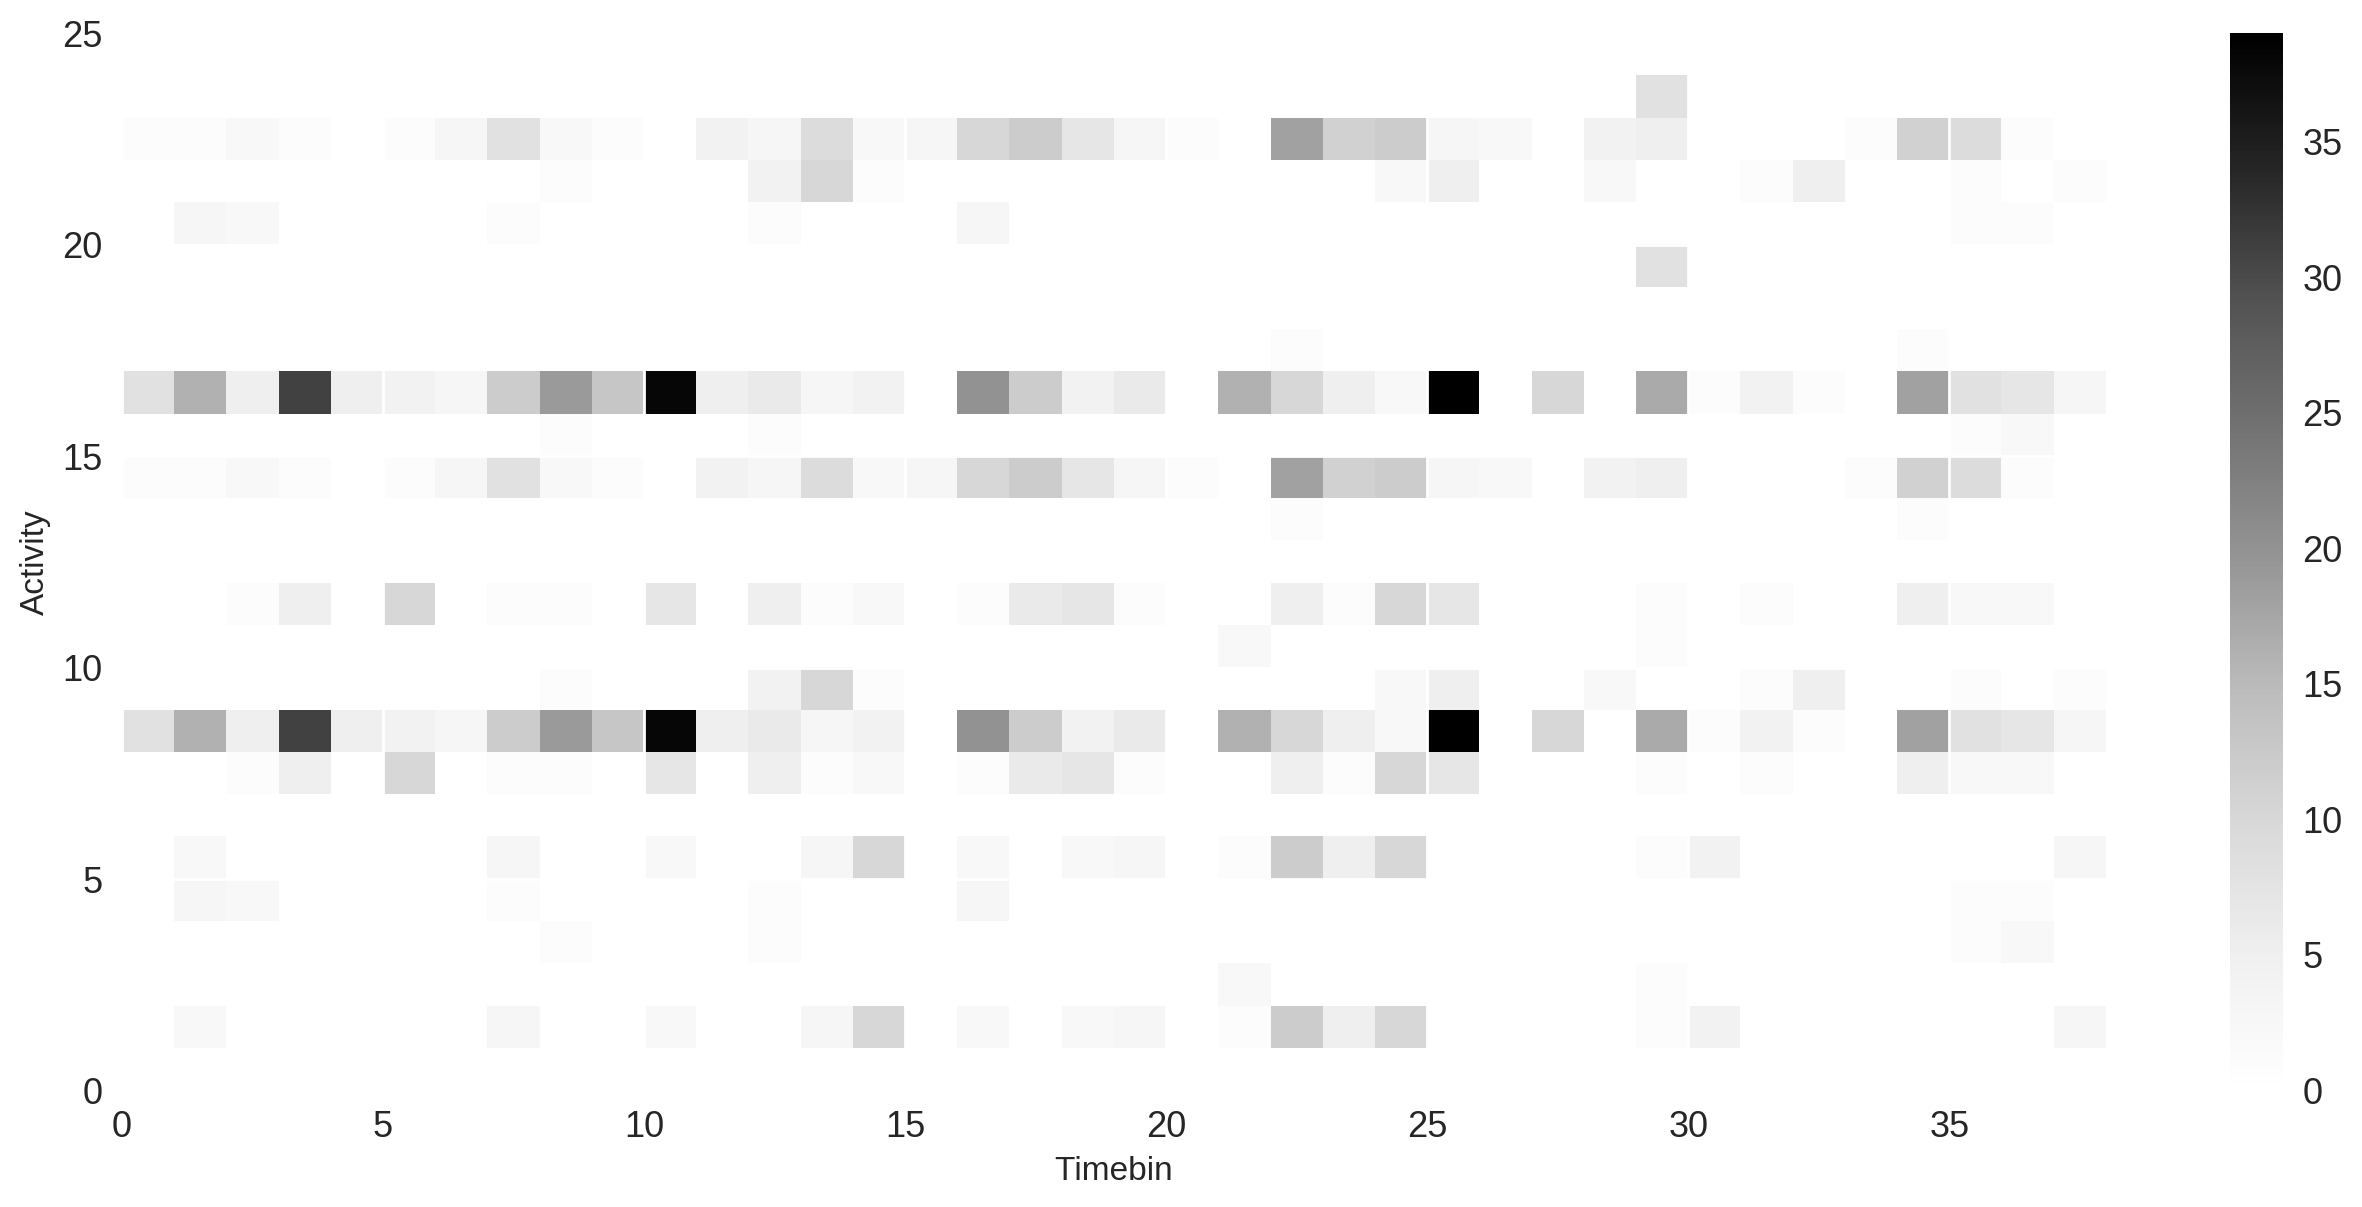

In [18]:

dcliqueSubDf = userDf2CliqueDf(df, chosenUserLst)
toPcaRaw = userDf2timebinAdjMat(cliqueSubDf, 6, chosenUserLst)

fig, ax = plt.subplots()
pc = ax.pcolorfast(toPcaRaw) 
fig.colorbar(pc)
ax.set_ylabel("Activity")
ax.set_xlabel('Timebin')

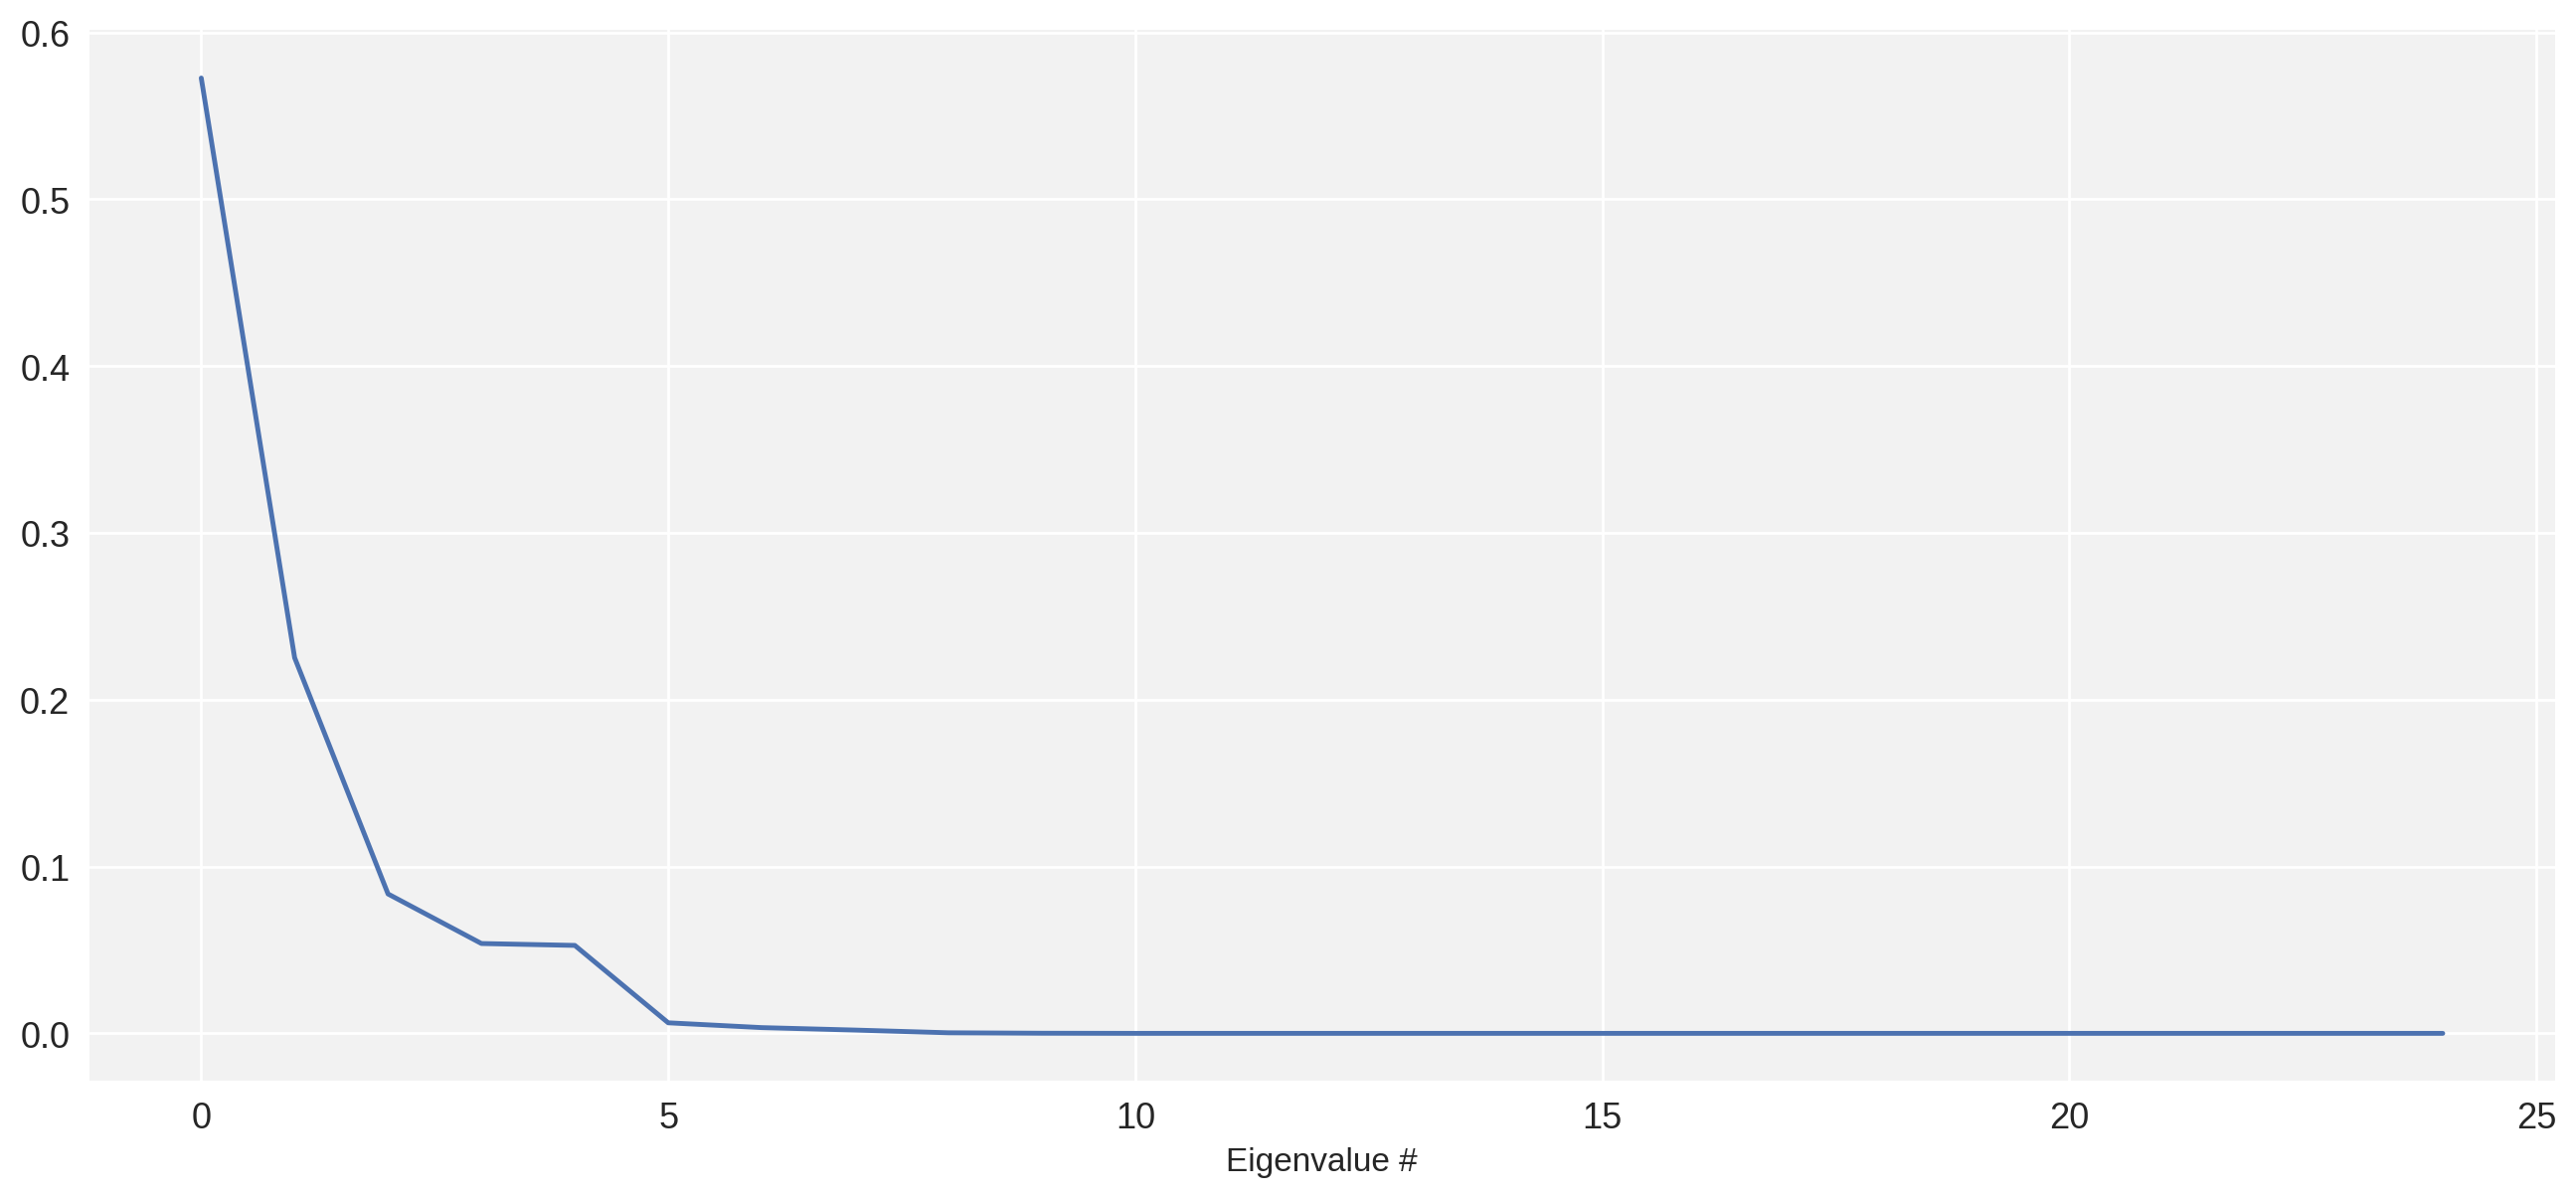

In [19]:
pca = pcaFit(toPcaRaw)

fig, ax = plt.subplots()
ax.plot(pca.explained_variance_ratio_)
ax.set_xlabel('Eigenvalue #') 

In [20]:
cliqueDf = pd.DataFrame(nx.clique.find_cliques_recursive(g))
cliqueDf['cliqueSize'] = cliqueDf.count(axis=1)
cliqueDf = cliqueDf.sort_values('cliqueSize', ascending=False)

binsCalendarDay = 6
cliqueSizeUnique = [x for x in cliqueDf.cliqueSize.unique() if x > 2]
cliquePcaDct = communityDf2PcaExplVarRatio(df, cliqueDf.drop('cliqueSize', axis=1), binsCalendarDay, cliqueSizeUnique)

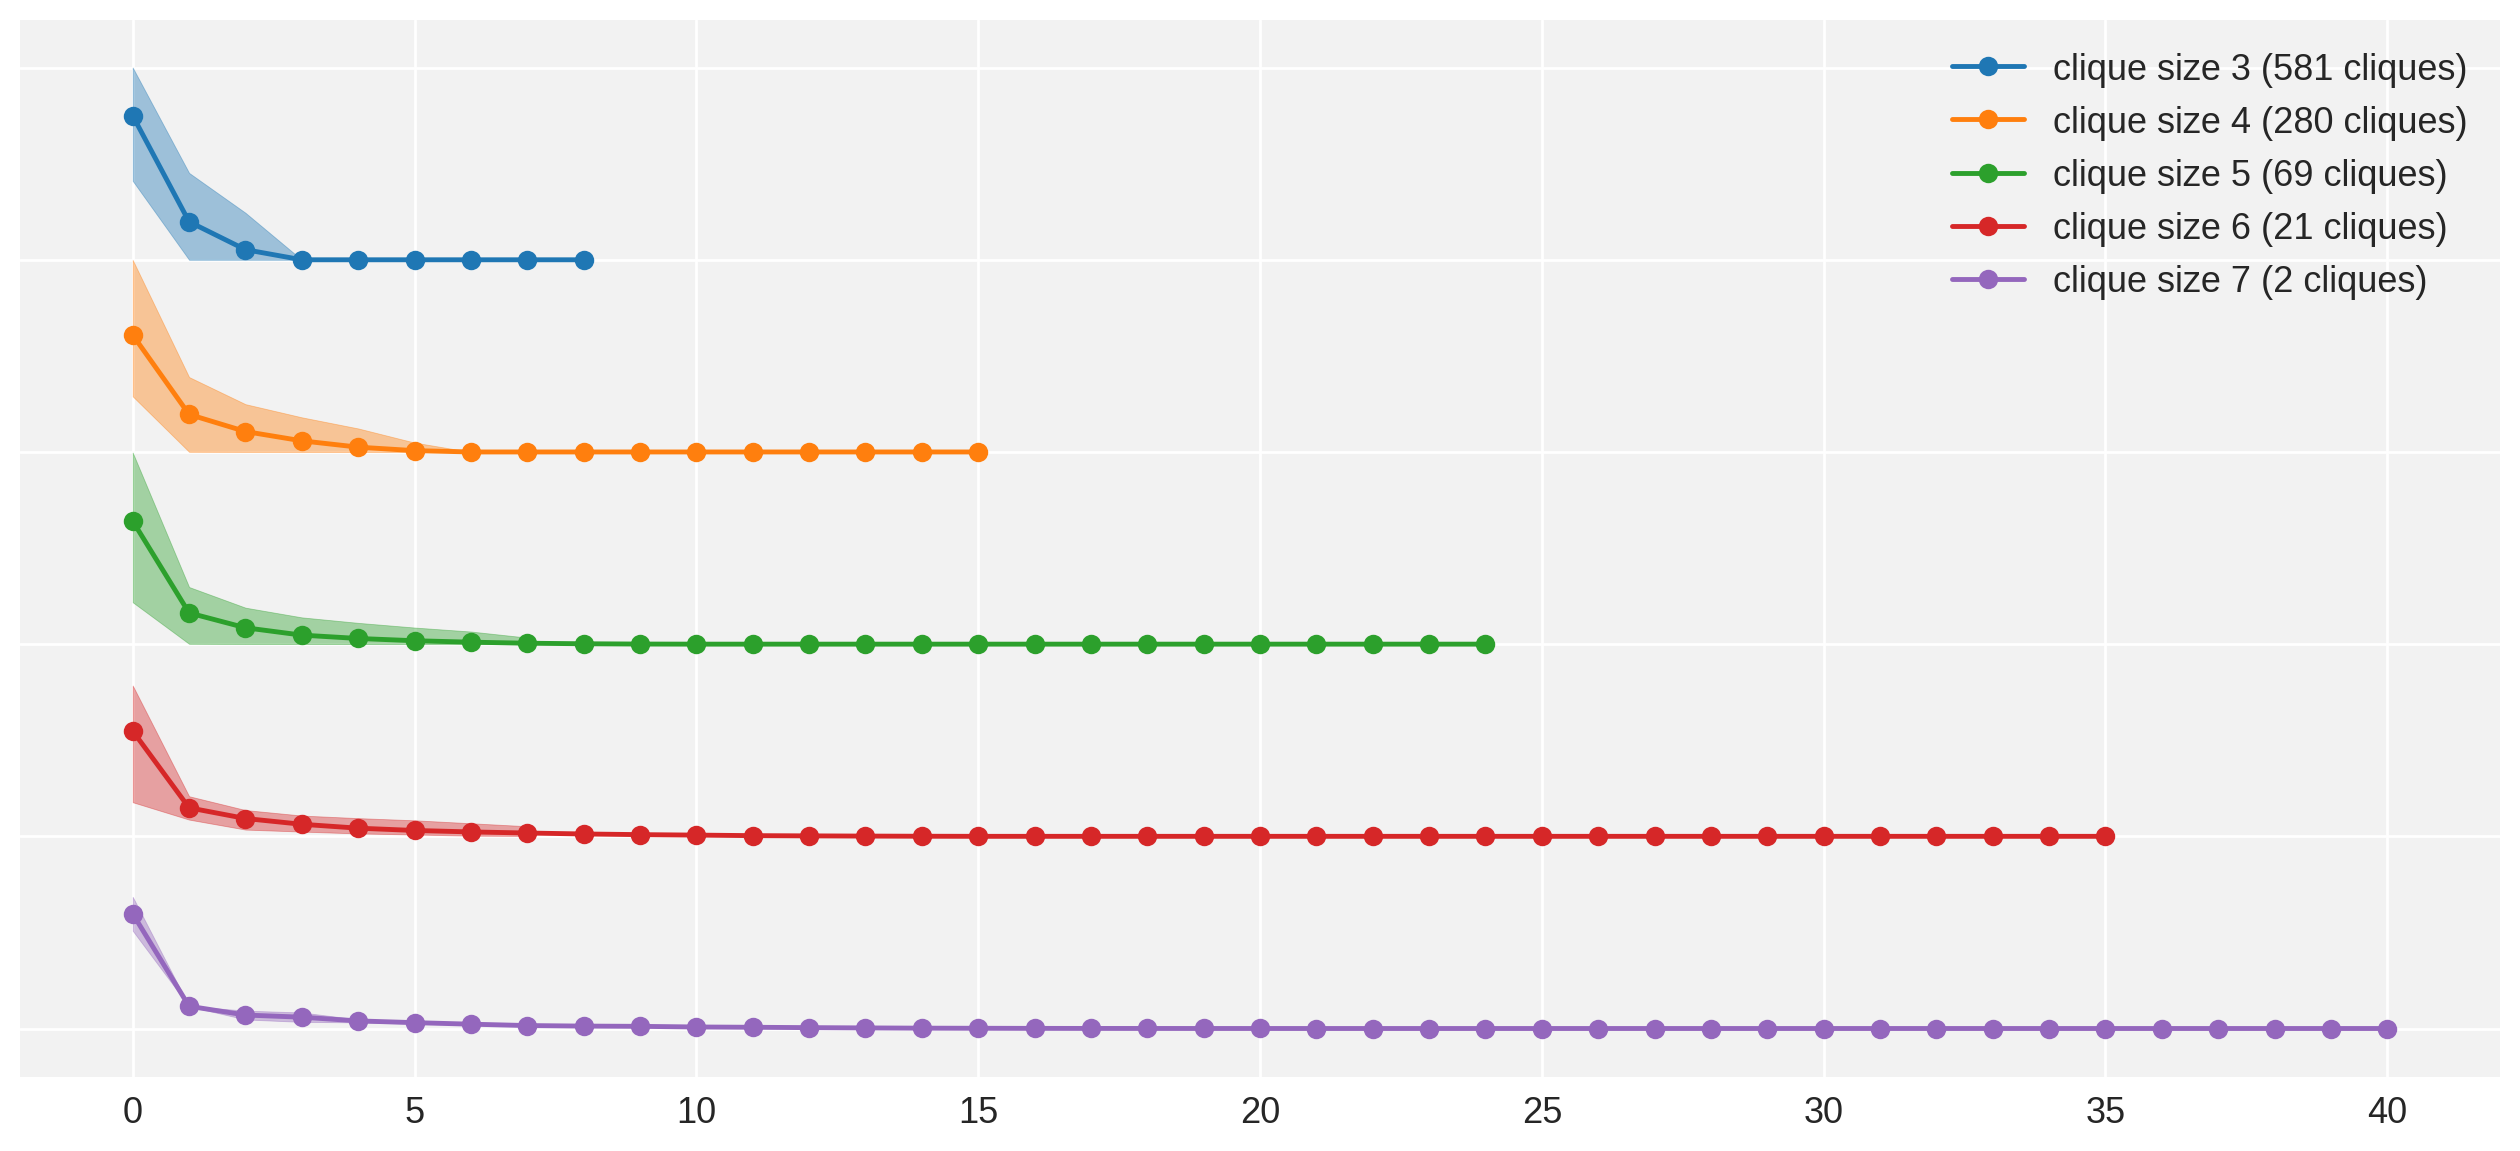

In [21]:
fig, ax = plt.subplots() 
colors = palettable.tableau.Tableau_10.mpl_colors
nPointsIncluded = 8
for i, cs in enumerate(sorted(cliquePcaDct.keys())):
    offset = len(cliquePcaDct) - i
    csDf = pd.DataFrame(cliquePcaDct[cs])
    upper, mean, median, lower, std = csDf.max(axis=0), csDf.mean(axis=0), csDf.median(axis=0), csDf.min(axis=0), csDf.std(axis=0)
    ax.plot(mean+offset, '-o', color=colors[i], label='clique size %d (%d cliques)' % (cs, len(cliquePcaDct[cs])))
    # ax.errorbar(range(len(mean))[:nPointsIncluded], mean[:nPointsIncluded]+offset, uplims=upper, lolims=lower, color=colors[i])
    ax.fill_between(range(nPointsIncluded), upper[:nPointsIncluded]+offset, lower[:nPointsIncluded]+offset, color=colors[i], alpha=0.4)
ax.set_yticklabels(sorted(cliquePcaDct.keys()))
ax.legend(loc='best', fancybox=True, framealpha=0.8)
ax.set_yticklabels([]); 
# ax.set_yscale('log') 

### Do the same for the communities

In [22]:
binsCalendarDay = 6
# communityPcaDct = dict()
communitySizeArr = kcDf.communitySize.unique()[kcDf.communitySize.unique() >= cliqueDf.cliqueSize.max()]
communityPcaDct = communityDf2PcaExplVarRatio(df, kcDf.drop('communitySize', axis=1), binsCalendarDay)  #, communitySizeArr) 

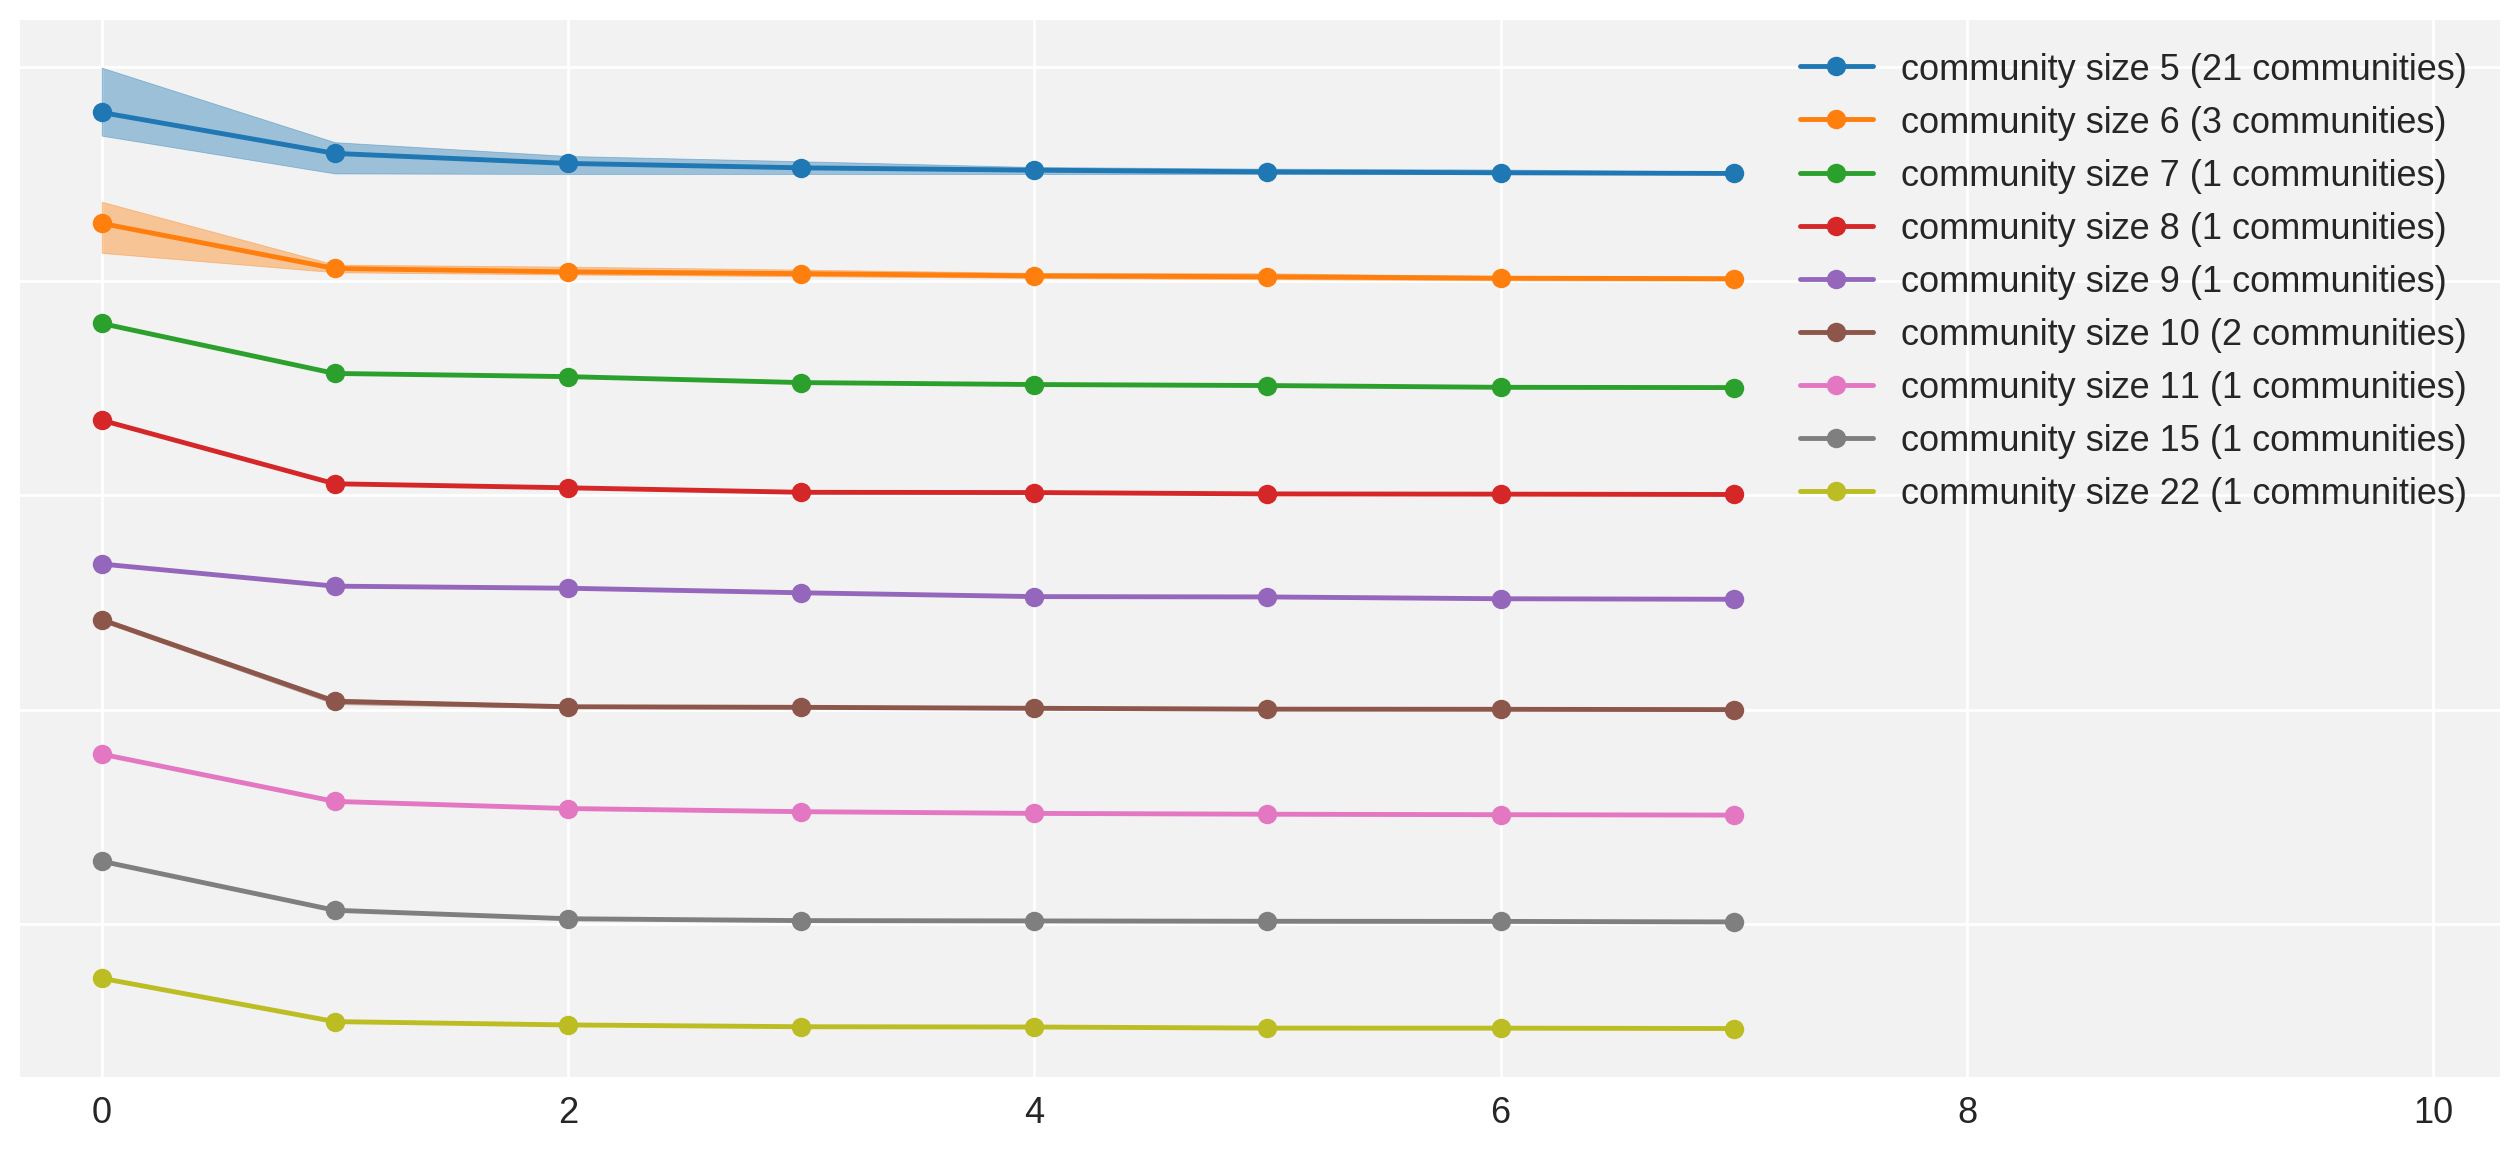

In [23]:
fig, ax = plt.subplots() 
colors = palettable.tableau.Tableau_10.mpl_colors  # .colorbrewer.qualitative.Set1_9_r.mpl_colors
nPointsIncluded = 8
for i, cs in enumerate(sorted(communityPcaDct.keys())):
    offset = len(communityPcaDct) - i
    csDf = pd.DataFrame(communityPcaDct[cs])
    upper, mean, median, lower, std = csDf.max(axis=0), csDf.mean(axis=0), csDf.median(axis=0), csDf.min(axis=0), csDf.std(axis=0)
    ax.plot(mean[:nPointsIncluded]+offset, '-o', color=colors[i], label='community size %d (%d communities)' % (cs, len(communityPcaDct[cs])))
    # ax.errorbar(range(len(mean)), mean+offset, uplims=upper, lolims=lower, color=colors[i])
    ax.fill_between(range(nPointsIncluded), upper[:nPointsIncluded]+offset, lower[:nPointsIncluded]+offset, color=colors[i], alpha=0.4)
ax.legend(loc='best')
ax.set_yticklabels([])
ax.set_xbound(upper=nPointsIncluded*9/7)
# ax.set_yscale('log') 

# Experiment with weights…

Verify that weights are included in the graphs and the adjacency matrices

In [26]:
ddf = userDf2CliqueDf(df.loc[cliqueDf.iloc[0, :-1].tolist(), :], cliqueDf.iloc[0, :-1].tolist())
disp(ddf.head() )
gg = userDF2nxGraph(ddf) 
nx.get_edge_attributes(gg, 'u0388')

for ua, ub in gg.edges():
    print(gg[ua][ub]) 

gg.get_edge_data(ua, ub)

user comtype body  duration  hour     timeint  \
user  comtype                                                   
u0388 call     u0388    call  NaN       0.0    20  1384461130   
      call     u0388    call  NaN      35.0     9  1386580349   
      call     u0388    call  NaN       1.0     9  1386666075   
      call     u0388    call  NaN      33.0     8  1389773597   
      call     u0388    call  NaN       0.0    19  1391111292   

                        timestamp  weekday contactedUser  
user  comtype                                             
u0388 call    2013-11-14 20:32:10        3         u0446  
      call    2013-12-09 09:12:29        0         u0446  
      call    2013-12-10 09:01:15        1         u0446  
      call    2014-01-15 08:13:17        2         u0446  
      call    2014-01-30 19:48:12        3         u0446

{'weight': 17}
{'weight': 56}
{'weight': 14}
{'weight': 1474}
{'weight': 169}
{'weight': 107}
{'weight': 55}
{'weight': 101}
{'weight': 11}
{'weight': 126}
{'weight': 159}
{'weight': 263}
{'weight': 140}
{'weight': 78}
{'weight': 50}
{'weight': 7}
{'weight': 40}
{'weight': 71}
{'weight': 16}
{'weight': 1275}
{'weight': 50}


{'weight': 50}

In [33]:
np.array(nx.adjacency_matrix(gg).todense()) 

array([[   0,   17,   56,   14, 1474,  169,  107],
       [  17,    0,  159,  101,   11,  126,   55],
       [  56,  159,    0,  140,  263,   78,   50],
       [  14,  101,  140,    0,   40,   71,    7],
       [1474,   11,  263,   40,    0, 1275,   16],
       [ 169,  126,   78,   71, 1275,    0,   50],
       [ 107,   55,   50,    7,   16,   50,    0]], dtype=int64)

In [39]:
for row in cliqueDf.iterrows():
    print(row)

(1319, 0             u0645
1             u0618
2             u0676
3             u0388
4             u0683
5             u0993
6             u0446
cliqueSize        7
Name: 1319, dtype: object)
(1479, 0             u0324
1             u0503
2             u0392
3             u0211
4             u0073
5             u0930
6             u0146
cliqueSize        7
Name: 1479, dtype: object)
(1501, 0             u0324
1             u0981
2             u0150
3             u0627
4             u0400
5             u0491
6              None
cliqueSize        6
Name: 1501, dtype: object)
(1484, 0             u0324
1             u0146
2             u0073
3             u0930
4             u0607
5             u0211
6              None
cliqueSize        6
Name: 1484, dtype: object)
(1165, 0             u0489
1             u0128
2             u0491
3             u0287
4             u0813
5             u0758
6              None
cliqueSize        6
Name: 1165, dtype: object)
(1530, 0             u0324
1  